In [1]:
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Dropout, Activation, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

2022-10-13 23:17:04.989958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 23:17:05.103227: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 23:17:05.526777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-13 23:17:05.526820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [4]:
class VariableAutoencoder():
    def __init__(
            self,
            input_dim,
            encoder_conv_filters,
            encoder_conv_kernel_size,
            encoder_conv_strides,
            decoder_conv_filters,
            decoder_conv_kernel_size,
            decoder_conv_strides,
            z_dim,
            use_batch_norm=False,
            use_dropout=False
    ):
        self.name = 'autoencoder'
        self.input_dim = input_dim
        self.learning_rate = None

        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides

        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides

        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.layers_encoder_n = len(encoder_conv_filters)
        self.layers_decoder_n = len(decoder_conv_filters)

        self._build()

    def _build(self):
        encoder_input, encoder_output, shape = self._build_encoder()
        self._build_decoder(shape)
        model_output = self.decoder(encoder_output)
        # passes an image through the encoder and back through the decoder to generate a reconstruction
        self.model = Model(encoder_input, model_output)

    def _build_encoder(self):
        encoder_input = Input(shape=self.input_dim, name='encoder_input') # image
        x = encoder_input

        for i in range(self.layers_encoder_n):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i],
                kernel_size=self.encoder_conv_kernel_size[i],
                strides=self.encoder_conv_strides[i],
                padding='same',
                name='encoder_conv2d_' + str(i),
            )
            x = conv_layer(x)
            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate=0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x) # flatten to vector
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)
        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        # samples a point z in the latent space from the normal distribution defined by mu & log_var
        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output, name='encoder')

        return encoder_input, encoder_output, shape_before_flattening

    def _build_decoder(self, shape):
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(shape))(decoder_input)
        x = Reshape(shape)(x)

        for i in range(self.layers_decoder_n):
            conv_layer = Conv2DTranspose(
                filters=self.decoder_conv_filters[i],
                kernel_size=self.decoder_conv_kernel_size[i],
                strides=self.decoder_conv_strides[i],
                padding='same',
                name='decoder_conv2d_' + str(i),
            )
            x = conv_layer(x)

            is_last_iteration = i >= self.layers_decoder_n - 1

            if not is_last_iteration:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)

                x = LeakyReLU()(x)

                if self.use_dropout:
                    x = Dropout(rate=0.25)(x)

            if is_last_iteration:
                x = Activation('sigmoid')(x)

        decoder_output = x
        # takes a point in latent space and decodes it into the original image domain
        self.decoder = Model(decoder_input, decoder_output, name='decoder')

        return decoder_output

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

    def train(self, x_train, batch_size, epochs, lr_decay=1, shuffle=True):
        def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
            def schedule(epoch):
                return initial_lr * (decay_factor ** np.floor(epoch/step_size))
            return LearningRateScheduler(schedule)

        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        self.model.fit(
            x_train,
            x_train,
            batch_size=batch_size,
            shuffle=shuffle,
            epochs=epochs,
            callbacks=[lr_sched]
        )

In [5]:
VAE = VariableAutoencoder(
    input_dim=(28, 28, 1),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 3, 3, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    decoder_conv_filters=[64, 64, 32, 1],
    decoder_conv_kernel_size=[3, 3, 3, 3],
    decoder_conv_strides=[1, 2, 2, 1],
    z_dim=2,
    use_dropout=True,
    use_batch_norm=True,
)

Instructions for updating:
Colocations handled automatically by placer.


2022-10-13 23:17:06.811899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:17:06.834364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:17:06.834517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
VAE.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv2d_0 (Conv2D)      (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 28, 28, 32)   0           ['encoder_conv2d_0[0][0]']       
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['leaky_re_lu[0][0]']            
 alization)                                                                                 

In [7]:
VAE.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv2d_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0   

In [8]:
VAE.compile(learning_rate=0.0005, r_loss_factor=1000)

In [9]:
VAE.train(
    x_train[:1000],
    batch_size=32,
    epochs=200,
)

Train on 1000 samples


2022-10-13 23:17:08.406461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 23:17:08.406859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:17:08.407045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:17:08.407152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/200


2022-10-13 23:17:10.684898: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


1000/1000 [==============================] - 2s 2ms/sample - loss: 193.2454 - vae_r_loss: 187.1248 - vae_kl_loss: 6.1206 - lr: 5.0000e-04
Epoch 2/200
1000/1000 [==============================] - 1s 517us/sample - loss: 102.2347 - vae_r_loss: 96.0010 - vae_kl_loss: 6.2337 - lr: 5.0000e-04
Epoch 3/200
1000/1000 [==============================] - 1s 521us/sample - loss: 81.7718 - vae_r_loss: 76.1832 - vae_kl_loss: 5.5885 - lr: 5.0000e-04
Epoch 4/200
1000/1000 [==============================] - 1s 518us/sample - loss: 75.1959 - vae_r_loss: 69.8393 - vae_kl_loss: 5.3567 - lr: 5.0000e-04
Epoch 5/200
1000/1000 [==============================] - 1s 514us/sample - loss: 72.5681 - vae_r_loss: 67.2145 - vae_kl_loss: 5.3536 - lr: 5.0000e-04
Epoch 6/200
1000/1000 [==============================] - 1s 519us/sample - loss: 70.0469 - vae_r_loss: 65.1476 - vae_kl_loss: 4.8992 - lr: 5.0000e-04
Epoch 7/200
1000/1000 [==============================] - 1s 515us/sample - loss: 68.4140 - vae_r_loss: 63.7078 

/home/dev/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


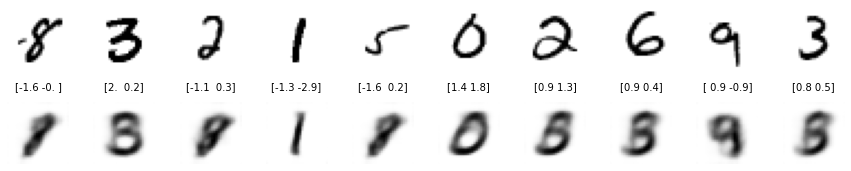

In [10]:
images_to_show = 10
example_images = x_test[
    np.random.choice(range(len(x_test)), images_to_show)
]
z_points = VAE.encoder.predict(example_images)
images_reconstructed = VAE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(images_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, images_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(images_to_show):
    img = images_reconstructed[i].squeeze()
    ax = fig.add_subplot(2, images_to_show, i + images_to_show + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


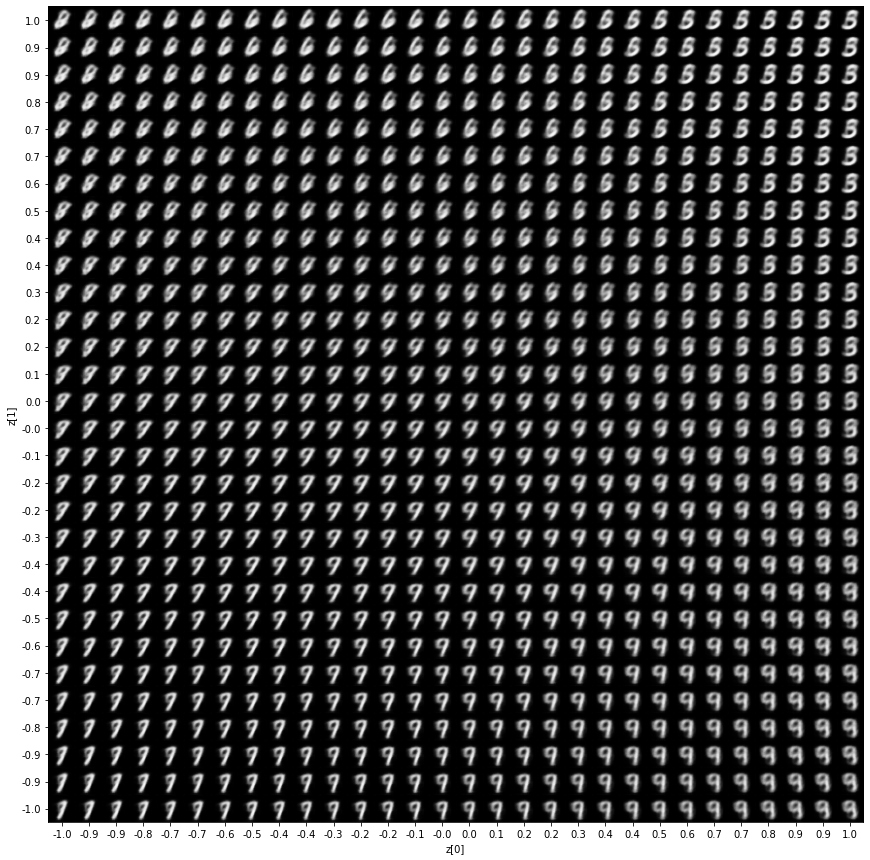

In [11]:
# from https://keras.io/examples/generative/vae/
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(VAE)

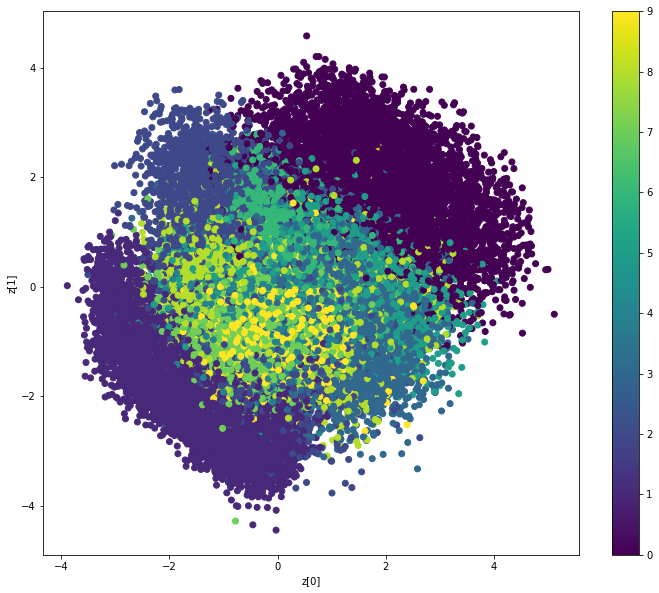

In [16]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(VAE, x_train, y_train)